In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
import scipy.sparse.linalg as spla
import scipy.io as sio
import meshio
import dolfin as dl
from time import time

import localpsfcpp as lpsf

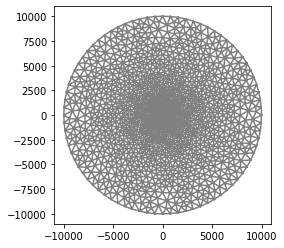

In [2]:
vertices = np.loadtxt('../data/mesh_vertices.txt')
cells = np.loadtxt('../data/mesh_cells.txt', dtype=int)
dof_coords = np.loadtxt('../data/dof_coords.txt')
vertex_in_dof = np.loadtxt('../data/vertex_in_dof.txt', dtype=int)
dof_in_vertex = np.loadtxt('../data/dof_in_vertex.txt', dtype=int)

mesh_meshio = meshio.Mesh(vertices, [("triangle", cells)])
mesh_meshio.write("mesh.xml")
mesh = dl.Mesh("mesh.xml")
dl.plot(mesh)

In [3]:
Hdgn = np.loadtxt('../data/Hdgn_array.txt')
sqrtR = sio.loadmat('../data/sqrtR_matrix.mat')['sqrtR']
M = sio.loadmat('../data/mass_matrix.mat')['M']
# mass_lumps = np.loadtxt('mass_matrix_diagonal.txt')
mass_lumps = M * np.ones(M.shape[1])

Ker = Hdgn / (mass_lumps.reshape(1,-1) * mass_lumps.reshape(-1,1))

apply_Hdgn = lambda x: np.dot(Hdgn, x)
apply_HdgnT = lambda x: np.dot(Hdgn, x)
apply_M = lambda x: M * x
solve_M = spla.factorized(M)
apply_ML = lambda x: x * mass_lumps
solve_ML = lambda x: x / mass_lumps

In [4]:
R = sqrtR.toarray().T @ np.linalg.solve(M.toarray(), sqrtR.toarray())

In [5]:
V = dl.FunctionSpace(mesh, 'CG', 1)

err_dof_coords = np.linalg.norm(dof_coords - V.tabulate_dof_coordinates()) / np.linalg.norm(V.tabulate_dof_coordinates())
print('err_dof_coords=', err_dof_coords)

err_dof_coords= 0.0


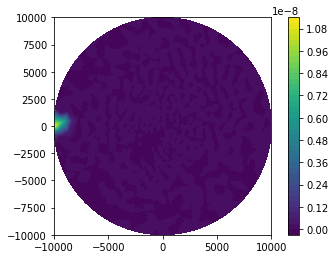

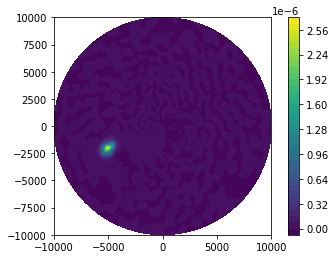

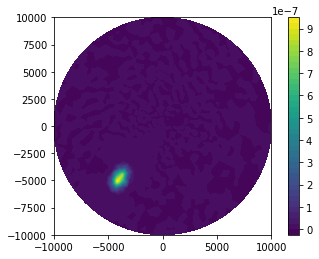

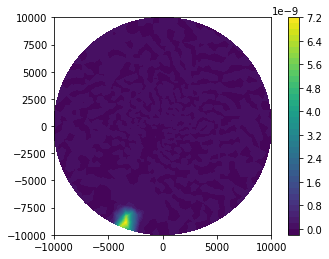

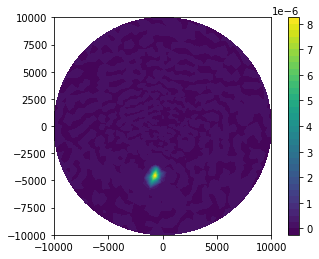

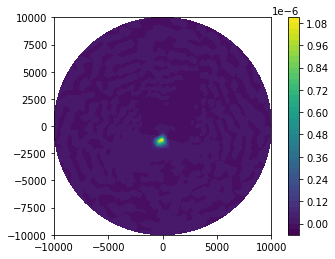

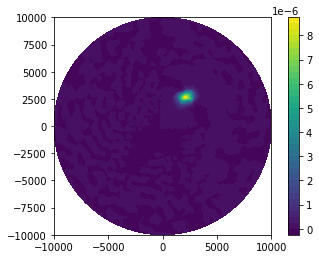

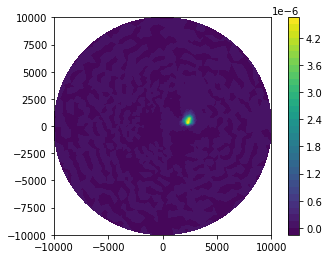

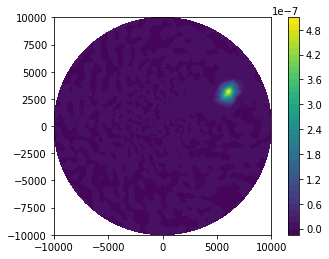

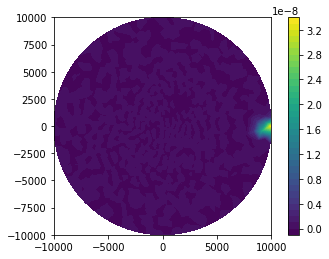

In [6]:
kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)

In [7]:
err_reorder = np.linalg.norm(dof_coords - vertices[dof_in_vertex,:]) / np.linalg.norm(dof_coords)
print('err_reorder=', err_reorder)

vertices_dof_order = np.array(vertices[dof_in_vertex,:].T, order='C')
# cells_dof_order    = np.array(cells[dof_in_vertex,:].T,    order='C') # BAD
cells_dof_order    = np.array(vertex_in_dof[cells].T,    order='C') # GOOD

err_reorder= 0.0


In [8]:
from matplotlib.patches import Ellipse

def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    if not ('edgecolor' in kwargs):
        kwargs['edgecolor'] = 'k'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1


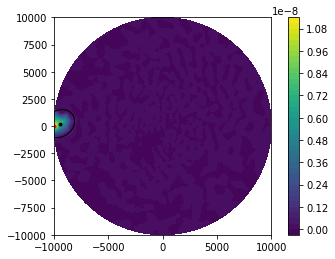

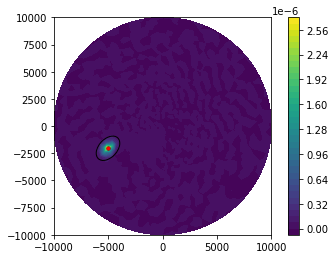

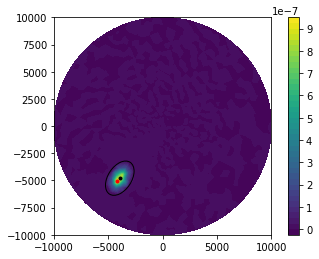

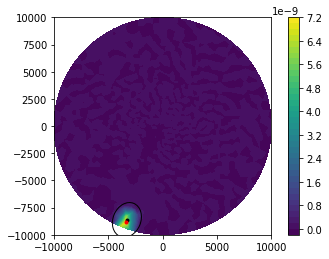

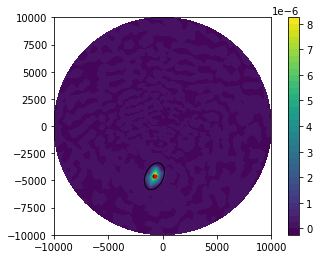

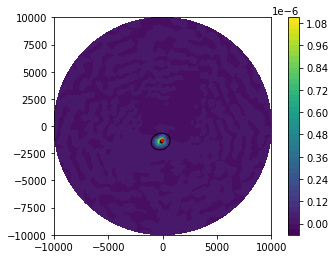

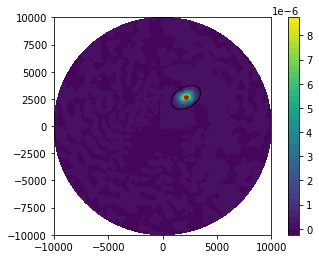

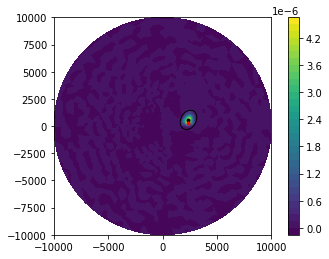

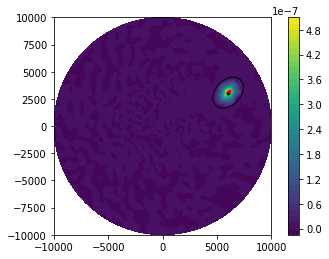

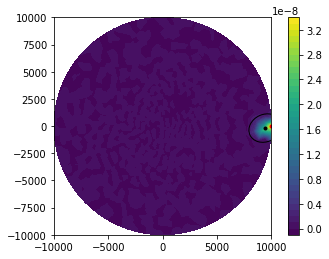

In [9]:
vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_ML, vertices_dof_order)
# vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_M, vertices_dof_order)

tau = 3.0

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.plot(mu[k][0], mu[k][1], '.k')
    plot_ellipse(mu[k], Sigma[k], tau, edgecolor='k')
    plt.plot(vertices_dof_order[0,k], vertices_dof_order[1,k], '.r')

In [10]:
num_neighbors = 10
min_vol_rtol = 1e-5
num_initial_batches = 5

lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, num_initial_batches)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch


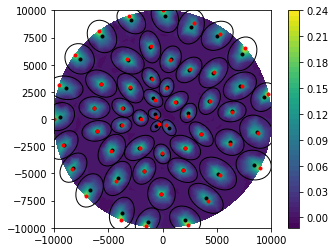

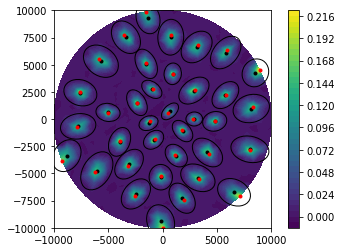

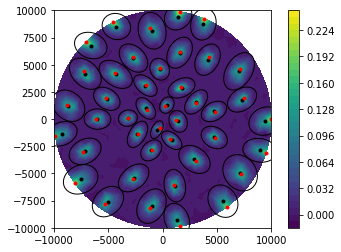

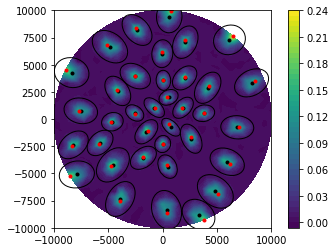

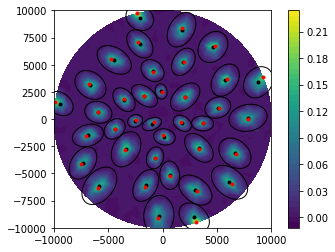

In [11]:
for b in range(len(lpsf_kernel.eta_batches)):
    eta_b = dl.Function(V)
    eta_b.vector()[:] = lpsf_kernel.eta_batches[b]

    plt.figure()
    cm = dl.plot(eta_b)
    plt.colorbar(cm)
    for ind in lpsf_kernel.dirac_ind_batches[b]:
        plt.plot(mu[ind][0], mu[ind][1], '.k')
        plot_ellipse(mu[ind], Sigma[ind], tau, edgecolor='k')
        plt.plot(vertices_dof_order[0,ind], vertices_dof_order[1,ind], '.r')

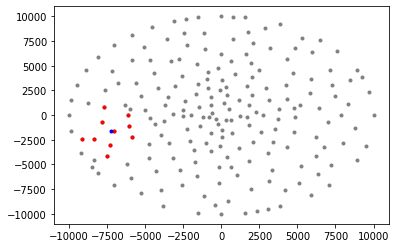

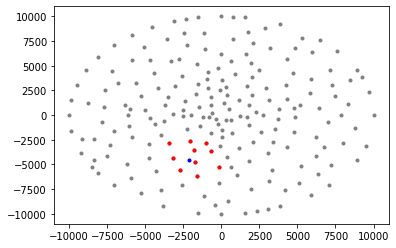

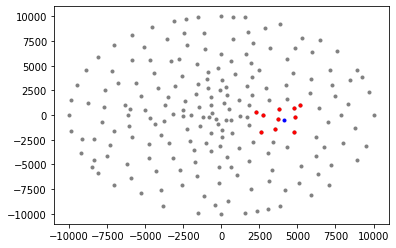

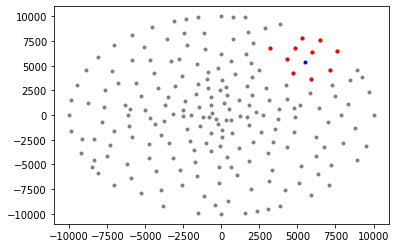

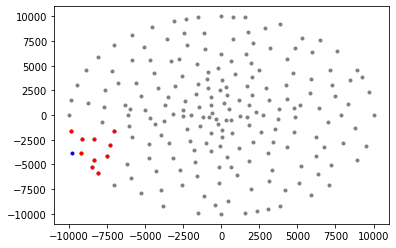

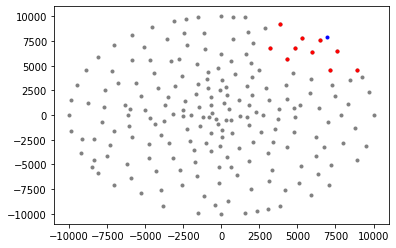

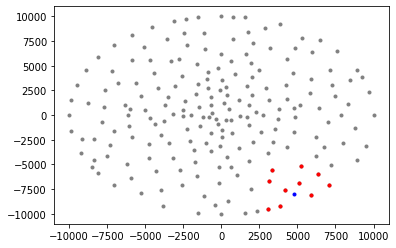

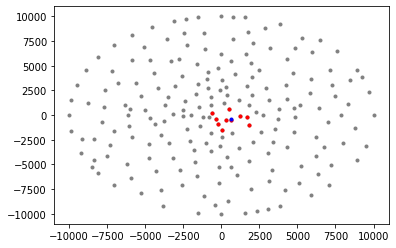

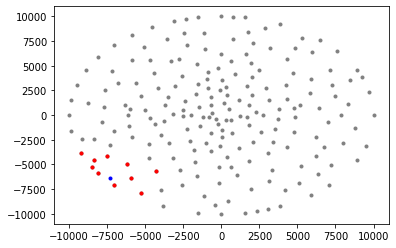

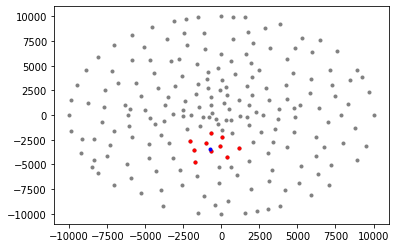

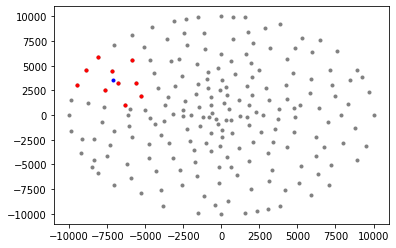

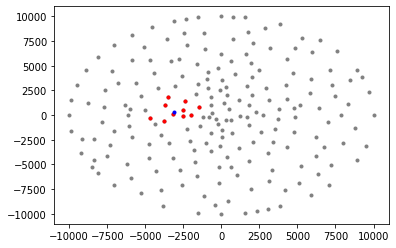

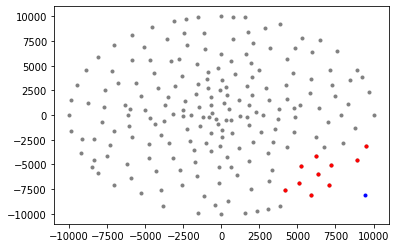

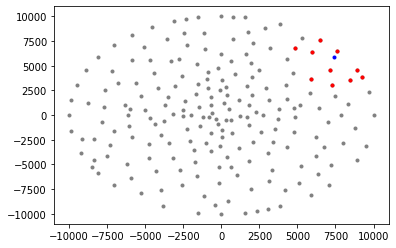

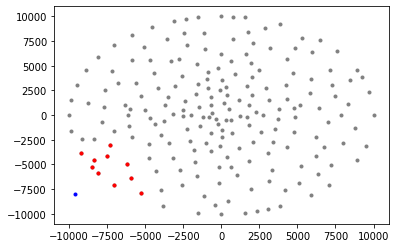

In [12]:
query_points = [np.array(1e4*(2*np.random.rand(2,1)-1), order='C') for _ in range(15)]

for q in query_points:
    nearest_inds = lpsf_kernel.dirac_kdtree.query(q, 10)[0].reshape(-1)

    plt.figure()
    for ind in lpsf_kernel.dirac_inds:
        plt.plot(lpsf_kernel.source_vertices[ind][0], lpsf_kernel.source_vertices[ind][1], '.', c='gray')

    for ind in nearest_inds:
            plt.plot(lpsf_kernel.dirac_points[ind][0], lpsf_kernel.dirac_points[ind][1], '.r')

    plt.plot(q[0], q[1], '.b')

In [13]:
R_ker = ( 1.0 / mass_lumps.reshape((-1,1)) ) * (R / mass_lumps.reshape((1,-1)))

num_entries = 15
row_inds = list(np.random.randint(0, V.dim(), num_entries))
# col_inds = list(np.random.randint(0, V.dim(), num_entries))
col_inds = row_inds

for ii, jj in zip(row_inds, col_inds):
    v_true = Ker[ii,jj]
    v_CUR = lpsf_kernel.entry(ii,jj,  lpsf.ShiftMethod.LOW_RANK,                           lpsf.ScalingMethod.NONE)
    v_LTI = lpsf_kernel.entry(ii,jj,  lpsf.ShiftMethod.LOCAL_TRANSLATION_INVARIANCE,       lpsf.ScalingMethod.NONE)
    v_LMDI = lpsf_kernel.entry(ii,jj, lpsf.ShiftMethod.LOCAL_MEAN_DISPLACEMENT_INVARIANCE, lpsf.ScalingMethod.VOL)
    v_ELL = lpsf_kernel.entry(ii,jj,  lpsf.ShiftMethod.ELLIPSOID_MAPPING,                  lpsf.ScalingMethod.DETVOL)

    print('ii=', ii, ', jj=', jj)
    print('value_true=', np.format_float_scientific(v_true, precision=3), 
          ', v_CUR=', np.format_float_scientific(v_CUR, precision=3), 
          ', v_LTI=', np.format_float_scientific(v_LTI, precision=3), 
          ', v_LMDI=', np.format_float_scientific(v_LMDI, precision=3), 
          ', v_ELL=', np.format_float_scientific(v_ELL, precision=3), 
          )

ii= 41 , jj= 41
value_true= 6.609e-08 , v_CUR= 2.921e-08 , v_LTI= 2.381e-08 , v_LMDI= 5.983e-08 , v_ELL= 5.686e-08
ii= 786 , jj= 786
value_true= 1.092e-06 , v_CUR= 4.216e-07 , v_LTI= 1.410e-06 , v_LMDI= 7.587e-07 , v_ELL= 7.151e-07
ii= 1374 , jj= 1374
value_true= 8.716e-07 , v_CUR= 5.486e-07 , v_LTI= 1.374e-06 , v_LMDI= 9.666e-07 , v_ELL= 8.091e-07
ii= 79 , jj= 79
value_true= 1.116e-08 , v_CUR= 2.793e-09 , v_LTI= 9.076e-09 , v_LMDI= 5.721e-09 , v_ELL= 9.168e-09
ii= 920 , jj= 920
value_true= 4.511e-07 , v_CUR= 8.868e-08 , v_LTI= 4.567e-07 , v_LMDI= 3.719e-07 , v_ELL= 3.812e-07
ii= 346 , jj= 346
value_true= 3.004e-06 , v_CUR= 1.396e-06 , v_LTI= 3.323e-06 , v_LMDI= 2.599e-06 , v_ELL= 2.401e-06
ii= 1399 , jj= 1399
value_true= 1.076e-06 , v_CUR= 1.191e-07 , v_LTI= 1.088e-06 , v_LMDI= 8.744e-07 , v_ELL= 7.662e-07
ii= 1093 , jj= 1093
value_true= 9.576e-06 , v_CUR= 2.621e-06 , v_LTI= 8.644e-06 , v_LMDI= 8.137e-06 , v_ELL= 8.207e-06
ii= 1254 , jj= 1254
value_true= 4.757e-08 , v_CUR= 4.757e-08 ,

In [14]:
shift_method = lpsf.ShiftMethod.ELLIPSOID_MAPPING
scaling_method = lpsf.ScalingMethod.DETVOL
hmatrix_tol = 1e-6
display = True

ct = lpsf.build_cluster_tree_from_dof_coords(list(dof_coords), 32)
lpsf.visualize_cluster_tree(ct, "cluster_tree")

bct = lpsf.build_block_cluster_tree(ct, ct, 2.0)
lpsf.visualize_block_cluster_tree(bct, "block_cluster_tree")

Ker_hmatrix = lpsf.build_lpsfkernel_hmatrix(lpsf_kernel, bct, 
                                            shift_method, scaling_method,
                                            hmatrix_tol, display)

lpsf.visualize_hmatrix(Ker_hmatrix, "kernel_hmatrix")

━━ building H-matrix ( tol = 1e-06 )
[==========================                                        

In [15]:
num_entries = 15
row_inds = list(np.random.randint(0, V.dim(), num_entries))
# col_inds = list(np.random.randint(0, V.dim(), num_entries))
col_inds = row_inds

for ii, jj in zip(row_inds, col_inds):
    Kij = Ker[ii, jj]
    Kij_lpsf = lpsf_kernel.entry(ii, jj, shift_method, scaling_method)
    Kij_hmatrix = lpsf.TMatrix_entry(Ker_hmatrix, bct, ii, jj)
    print('ii=', ii, ', jj=', jj, ', Kij=', Kij, ', Kij_lpsf=', Kij_lpsf, ', Kij_hmatrix=', Kij_hmatrix)

    done in 4.33s
    size of H-matrix = 2.22 MB
ii= 1013 , jj= 1013 , Kij= 6.158750869611367e-06 , Kij_lpsf= 5.236682275366397e-06 , Kij_hmatrix= 5.236682275366397e-06
ii= 756 , jj= 756 , Kij= 8.357043729362812e-08 , Kij_lpsf= 8.357061968872884e-08 , Kij_hmatrix= 8.357061968872884e-08
ii= 458 , jj= 458 , Kij= 8.1588483225992e-06 , Kij_lpsf= 7.099937793478042e-06 , Kij_hmatrix= 7.099937793478042e-06
ii= 841 , jj= 841 , Kij= 3.093234897124629e-07 , Kij_lpsf= 0.0 , Kij_hmatrix= 0.0
ii= 1283 , jj= 1283 , Kij= 1.2094761353368891e-08 , Kij_lpsf= 1.1891592247542894e-08 , Kij_hmatrix= 1.1891592247542894e-08
ii= 1349 , jj= 1349 , Kij= 7.520506172252168e-07 , Kij_lpsf= 8.700086413298353e-07 , Kij_hmatrix= 8.700086413298353e-07
ii= 1312 , jj= 1312 , Kij= 8.89023020701819e-09 , Kij_lpsf= 5.243433260755718e-09 , Kij_hmatrix= 5.243433260755718e-09
ii= 73 , jj= 73 , Kij= 2.491776973855673e-07 , Kij_lpsf= 1.940842112905643e-07 , Kij_hmatrix= 1.940842112905643e-07
ii= 1057 , jj= 1057 , Kij= 5.03644590

In [16]:
num_rows = 50
num_cols = 73

row_inds = list(np.random.randint(0, V.dim(), num_rows))
col_inds = list(np.random.randint(0, V.dim(), num_cols))

B = Ker[np.ix_(row_inds, col_inds)]
B_lpsf = lpsf_kernel.block(row_inds, col_inds, shift_method, scaling_method)
B_hmatrix = lpsf.TMatrix_submatrix(Ker_hmatrix, bct, row_inds, col_inds)

err_B_lpsf = np.linalg.norm(B - B_lpsf) / np.linalg.norm(B)
print('err_B_lpsf=', err_B_lpsf)

err_B_hmatrix = np.linalg.norm(B - B_hmatrix) / np.linalg.norm(B)
print('err_B_hmatrix=', err_B_hmatrix)

err_B_hmatrix_vs_lpsf = np.linalg.norm(B_lpsf - B_hmatrix) / np.linalg.norm(B_lpsf)
print('err_B_hmatrix_vs_lpsf=', err_B_hmatrix_vs_lpsf)

err_B_lpsf= 0.16607885580292028
err_B_hmatrix= 0.16607885580292028
err_B_hmatrix_vs_lpsf= 0.0


In [17]:
block_size = V.dim()
# block_size = 200

row_inds = list(np.arange(block_size))
col_inds = list(np.arange(block_size))

B = Ker[np.ix_(row_inds, col_inds)]

t = time()
B_lpsf = lpsf_kernel.block(row_inds, col_inds, shift_method, scaling_method)
dt_lpsf = time() - t
print('dt_lpsf=', dt_lpsf)

t = time()
B_hmatrix = lpsf.TMatrix_submatrix(Ker_hmatrix, bct, row_inds, col_inds)
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

err_B_lpsf = np.linalg.norm(B - B_lpsf) / np.linalg.norm(B)
print('err_B_lpsf=', err_B_lpsf)

err_B_hmatrix = np.linalg.norm(B - B_hmatrix) / np.linalg.norm(B)
print('err_B_hmatrix=', err_B_hmatrix)

err_B_hmatrix_vs_lpsf = np.linalg.norm(B_lpsf - B_hmatrix) / np.linalg.norm(B_lpsf)
print('err_B_hmatrix_vs_lpsf=', err_B_hmatrix_vs_lpsf)

dt_lpsf= 36.61318063735962
dt_hmatrix= 0.33829402923583984
err_B_lpsf= 0.18605558342649106
err_B_hmatrix= 0.18605558342649106
err_B_hmatrix_vs_lpsf= 4.7218976482609506e-21


In [18]:
block_size = V.dim()
# block_size = 200

rows = list(np.arange(block_size))
cols = list(np.arange(block_size))

all_nB = [1, 5, 25]

all_nB_strs = ['nB= 1  ',
               'nB= 5  ',
               'nB=25  ']

all_nn = [1, 5, 10, 15]

all_nn_strs = ['nn= 1  ',
               'nn= 5  ',
               'nn=10  ',
               'nn=15  ']

shift_methods = [lpsf.ShiftMethod.LOW_RANK,
                 lpsf.ShiftMethod.LOCAL_TRANSLATION_INVARIANCE,
                 lpsf.ShiftMethod.LOCAL_MEAN_DISPLACEMENT_INVARIANCE,
                 lpsf.ShiftMethod.ELLIPSOID_MAPPING]

shift_strs = ['LR   ', 
              'LTI  ', 
              'LMDI ',
              'ELL  ']

scaling_methods = [lpsf.ScalingMethod.NONE,
                   lpsf.ScalingMethod.VOL,
                   lpsf.ScalingMethod.DET,
                   lpsf.ScalingMethod.DETVOL]

scaling_strs = ['NONE   ', 
                'VOL    ', 
                'DET    ',
                'DETVOL ']

B_true = Ker[np.ix_(rows, cols)]

errs_by_method = np.zeros((len(all_nB), len(all_nn), len(shift_methods), len(scaling_methods)))

# BBBB = [[[[[] for _ in range(len(all_nB))] 
#               for _ in range(len(all_nn))] 
#               for _ in range(len(shift_methods))] 
#               for _ in range(len(scaling_methods))]

initial_num_batches = 0
lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, initial_num_batches)

all_B = np.zeros((len(all_nB), 
                  len(all_nn), 
                  len(shift_methods), 
                  len(scaling_methods),
                  V.dim(),
                  V.dim()))

for ii, num_batches in enumerate(all_nB):
    while len(lpsf_kernel.eta_batches) < num_batches:
        lpsf_kernel.add_batch()
        
    for jj, num_neighbors in enumerate(all_nn):
        lpsf_kernel.num_neighbors = num_neighbors
        
        for kk, shift_method in enumerate(shift_methods):
            
            for ll, scaling_method in enumerate(scaling_methods):
                B_hmatrix = lpsf.build_lpsfkernel_hmatrix(lpsf_kernel, bct, 
                                                          shift_method, 
                                                          scaling_method,
                                                          hmatrix_tol, False)
                B = lpsf.TMatrix_submatrix(B_hmatrix, bct, rows, cols)
#                 B = lpsf_kernel.block(rows, cols, shift_method, scaling_method)
                err = np.linalg.norm(B_true - B) / np.linalg.norm(B_true)

#                 BBBB[ll][kk][jj][ii] = B
                all_B[ii,jj,kk,ll,:,:] = B
                errs_by_method[ii, jj, kk, ll] = err

                print(all_nB_strs[ii] + all_nn_strs[jj] + shift_strs[kk] + scaling_strs[ll] 
                      + 'err=', '{0: <.4f}'.format(err))

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
computing impulse response batch
nB= 1  nn= 1  LR   NONE   err= 1.2185
nB= 1  nn= 1  LR   VOL    err= 1.2862
nB= 1  nn= 1  LR   DET    err= 1.2708
nB= 1  nn= 1  LR   DETVOL err= 1.1999
nB= 1  nn= 1  LTI  NONE   err= 0.6786
nB= 1  nn= 1  LTI  VOL    err= 0.4395
nB= 1  nn= 1  LTI  DET    err= 0.7865
nB= 1  nn= 1  LTI  DETVOL err= 0.4237
nB= 1  nn= 1  LMDI NONE   err= 0.6452
nB= 1  nn= 1  LMDI VOL    err= 0.3198
nB= 1  nn= 1  LMDI DET    err= 0.7540
nB= 1  nn= 1  LMDI DETVOL err= 0.3535
nB= 1  nn= 1  ELL  NONE   err= 0.6101
nB= 1  nn= 1  ELL  VOL    err= 0.4141
nB= 1  nn= 1  ELL  DET    err= 0.6647
nB= 1  nn= 1  ELL  DETVOL err= 0.2555
nB= 1  nn= 5  LR   NONE   err= 1.9484
nB= 1  nn= 5  LR   VOL    err= 2.8475
nB= 1  nn= 5  LR   DET    err= 1.7676
nB= 1  nn= 5  LR   DETVOL err= 1.8263
nB= 1  nn= 5  LTI  NONE   err= 1.4809
nB= 1  nn= 5  LTI  VOL    err= 1.1633
nB= 1  nn= 5  LTI  DET    err= 

nB=25  nn=15  ELL  DETVOL err= 0.1199


In [72]:
all_B = np.zeros((len(all_nB), 
                  len(all_nn), 
                  len(shift_methods), 
                  len(scaling_methods),
                  V.dim(),
                  V.dim()))

for ii, num_batches in enumerate(all_nB):
    for jj, num_neighbors in enumerate(all_nn):
        for kk, shift_method in enumerate(shift_methods):
            for ll, scaling_method in enumerate(scaling_methods):
                all_B[ii,jj,kk,ll,:,:] = BBBB[ll][kk][jj][ii]

In [75]:
sio.savemat('all_kernel_approximations.mat', 
            {'K_true' : B_true,
             'all_K_approximations' : all_B,
             'all_num_batches' : all_nB,
             'all_num_neighbors' : all_nn,
             'shift_methods' : [str(method) for method in shift_methods],
             'scaling_methods' : [str(method) for method in scaling_methods],
             'approximation_errors' : errs_by_method})

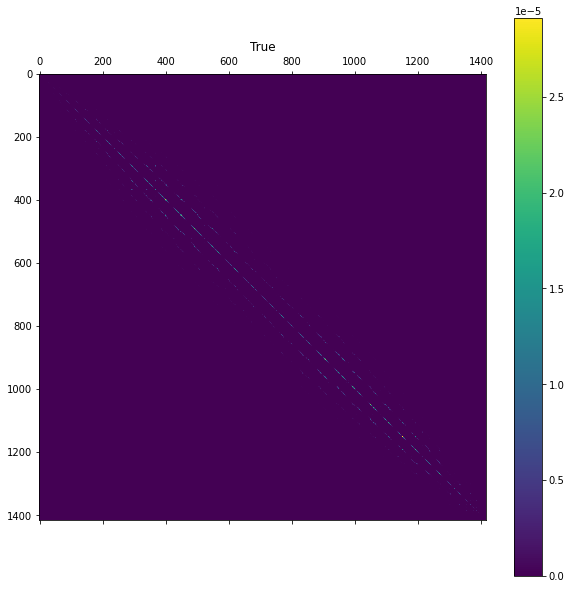

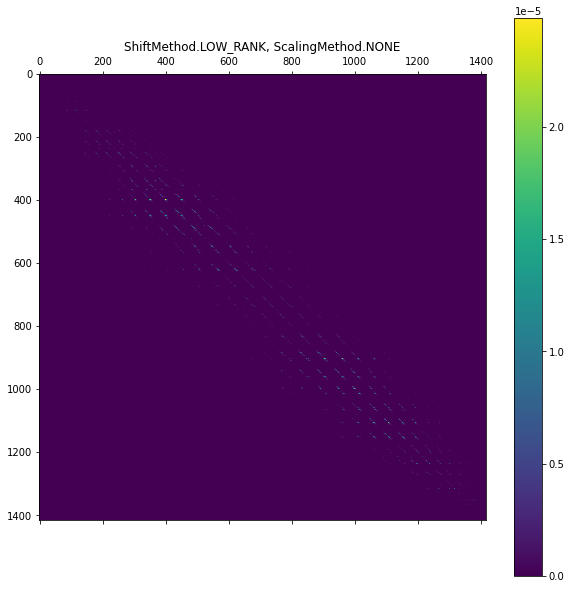

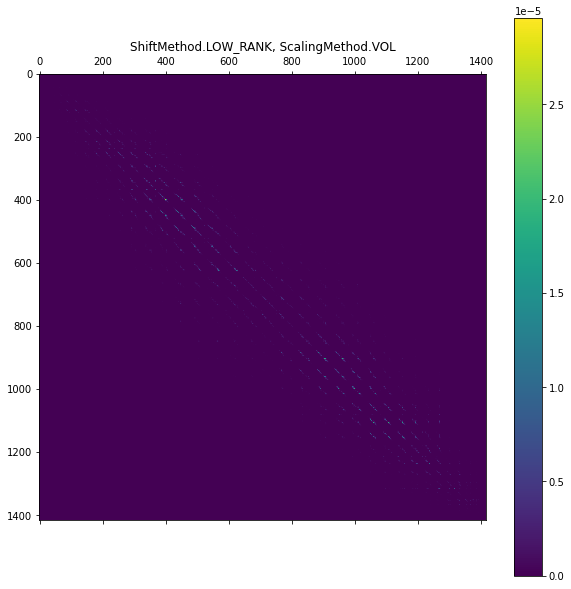

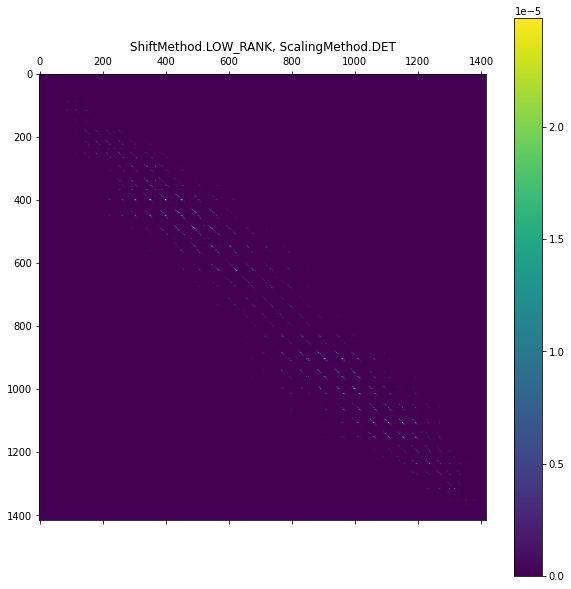

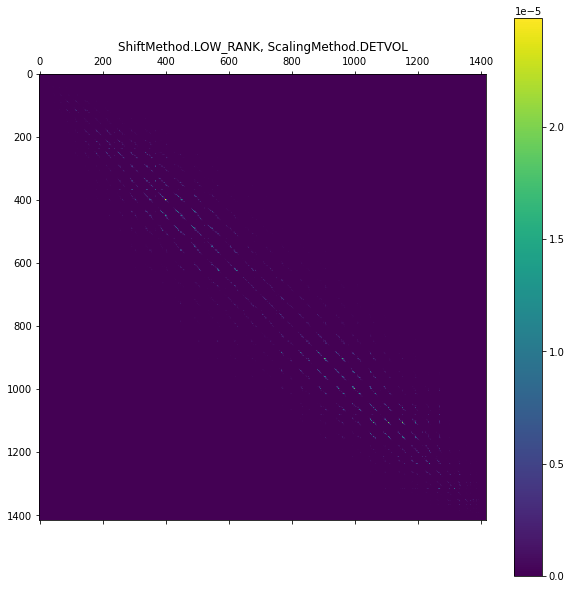

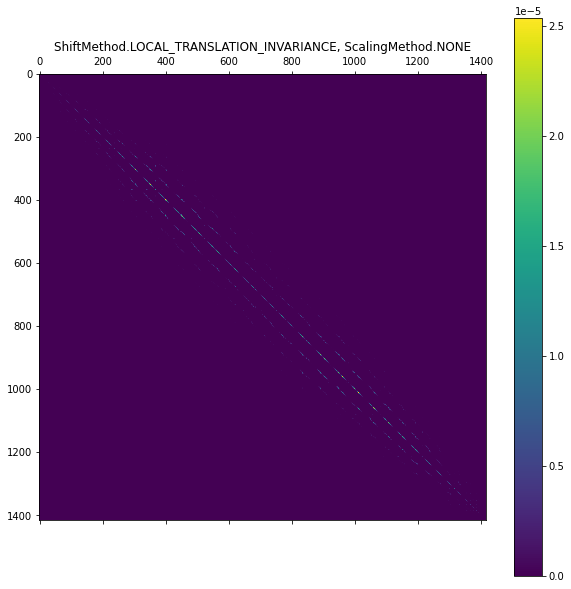

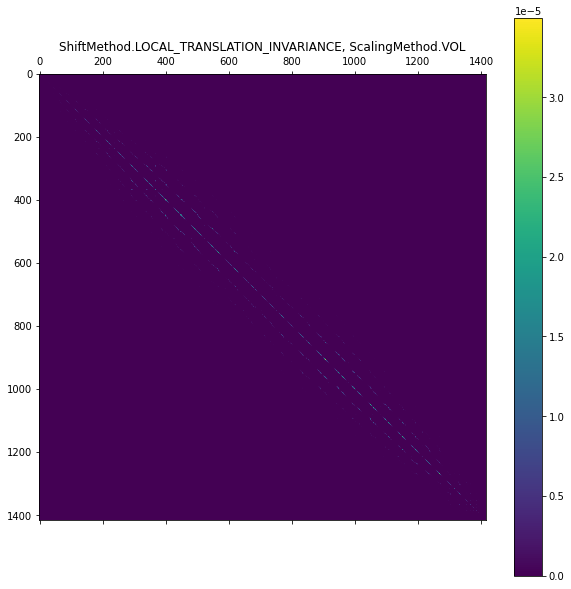

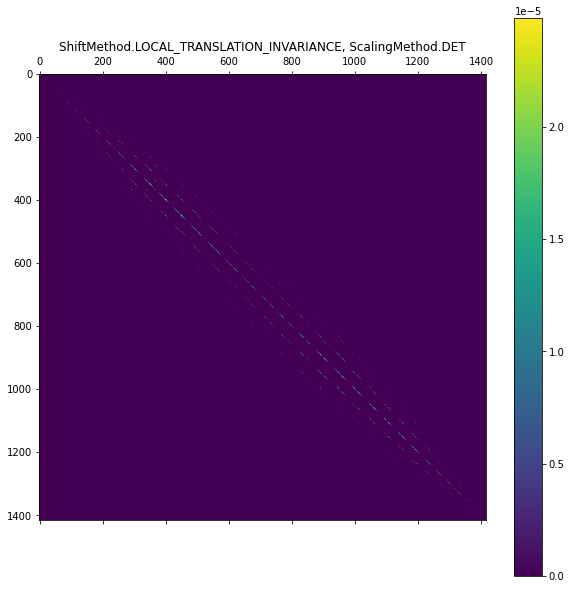

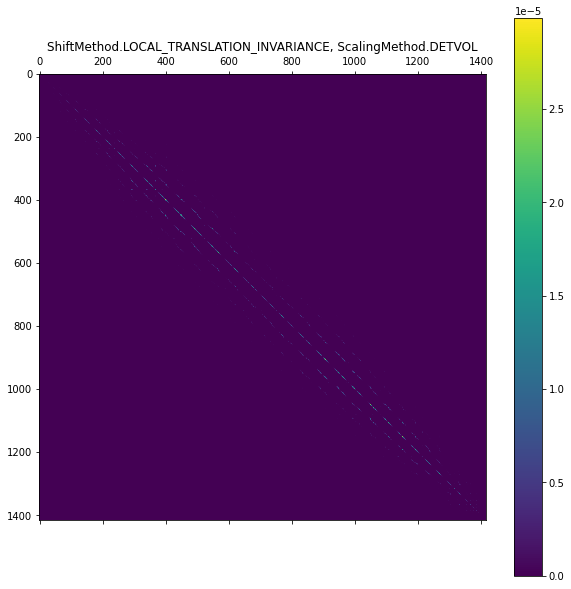

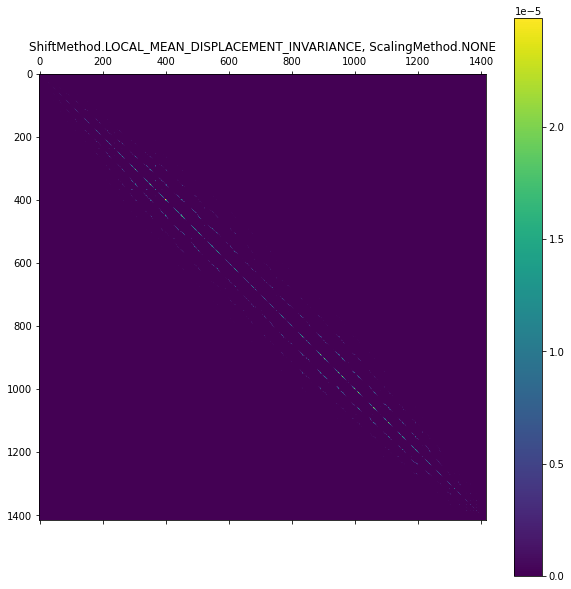

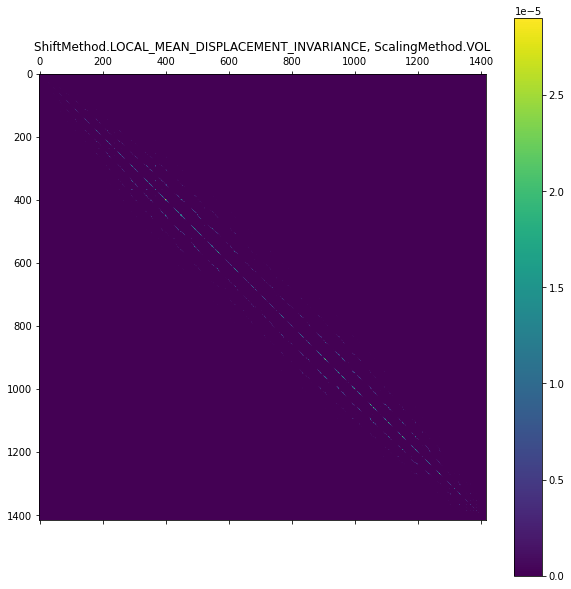

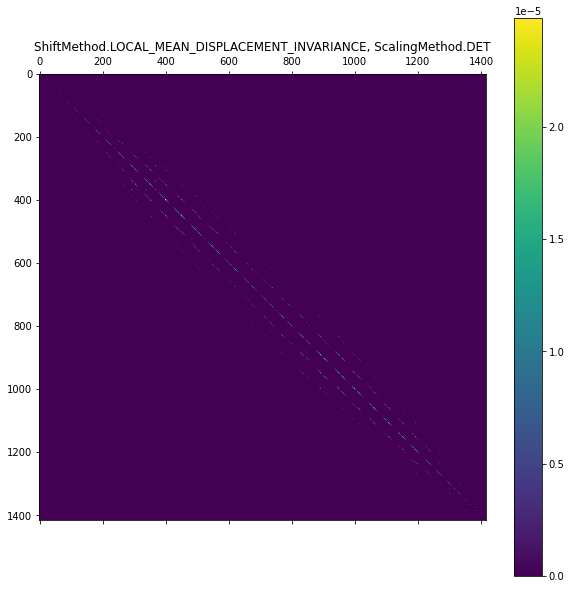

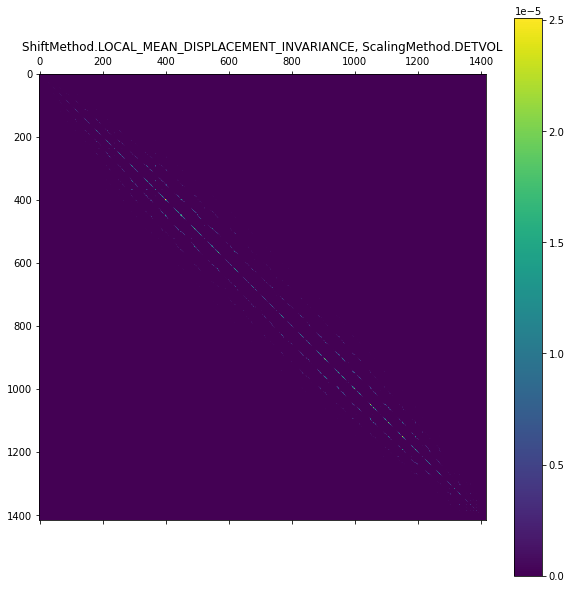

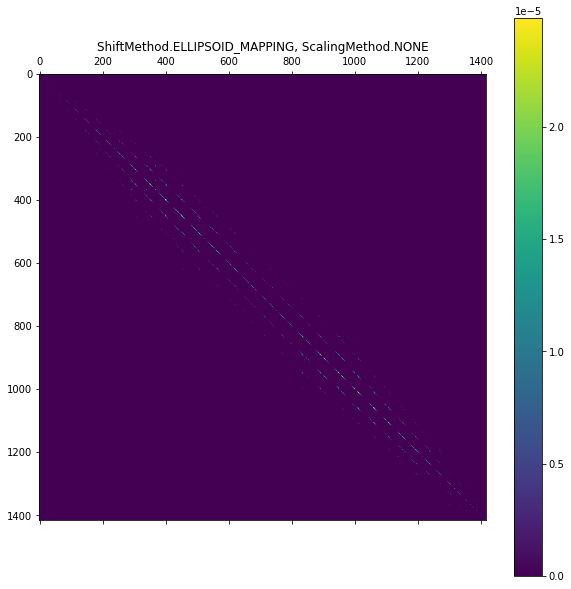

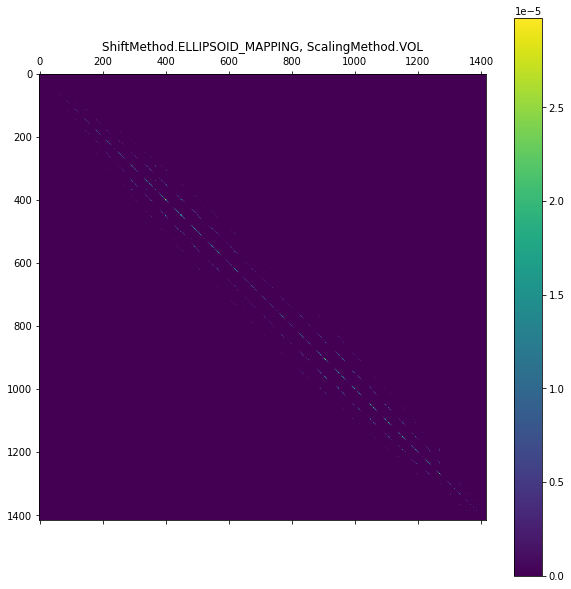

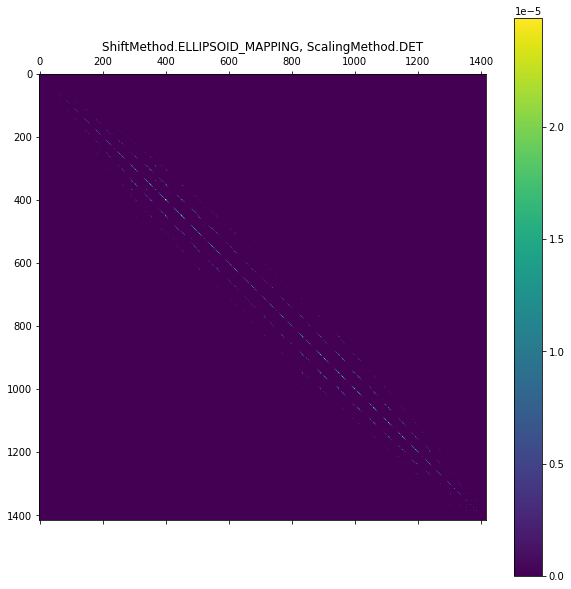

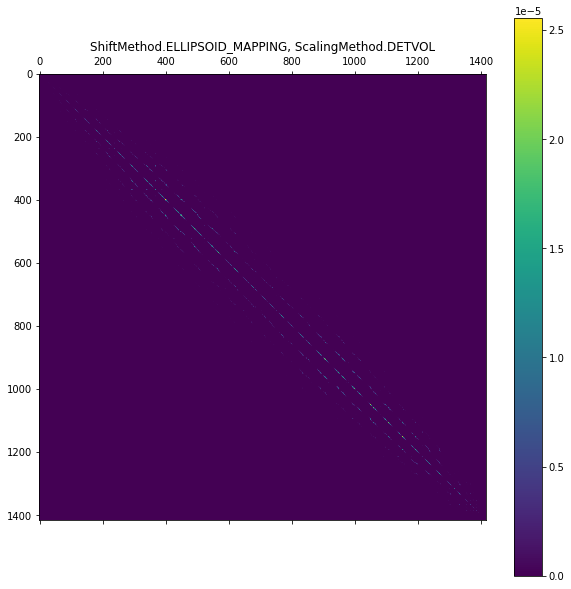

In [56]:
jjj = 1

plt.figure(figsize=(10,10))
plt.matshow(np.abs(B_true), fignum=jjj)
jjj += 1
plt.colorbar()
plt.title('True')

errs_by_method = np.zeros((len(shift_methods), len(scaling_methods)))
for ii, shift_method in enumerate(shift_methods):
    for jj, scaling_method in enumerate(scaling_methods):
        plt.figure(figsize=(10,10))
        plt.matshow(np.abs(BB[ii][jj]), fignum=jjj)
        jjj += 1
        plt.colorbar()
        plt.title(str(shift_method)+ ', ' + str(scaling_method))

/tmp/ipykernel_603776/3776181403.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

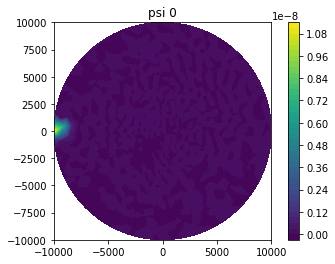

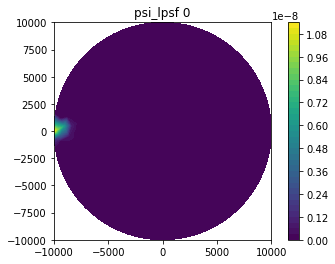

<Figure size 432x288 with 0 Axes>

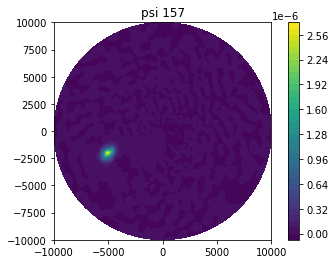

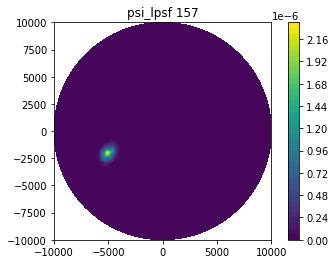

<Figure size 432x288 with 0 Axes>

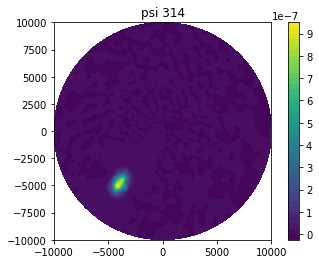

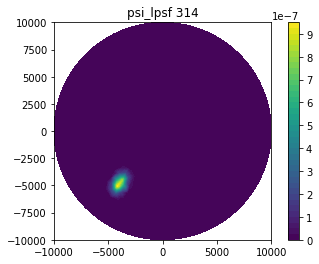

<Figure size 432x288 with 0 Axes>

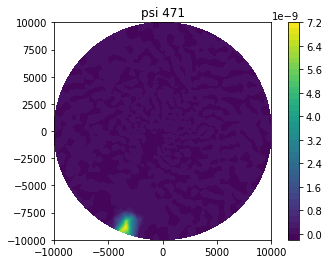

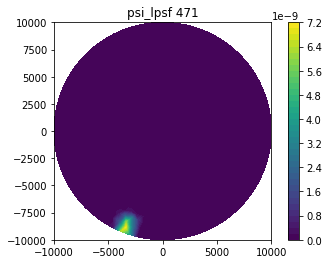

<Figure size 432x288 with 0 Axes>

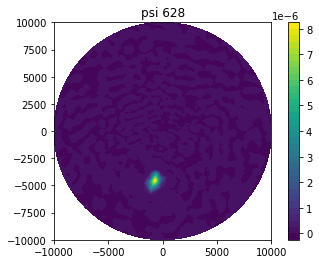

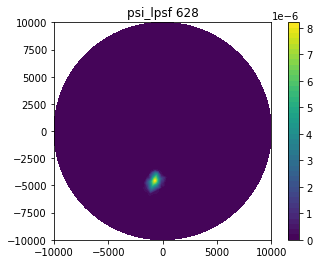

<Figure size 432x288 with 0 Axes>

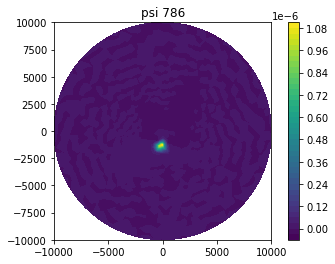

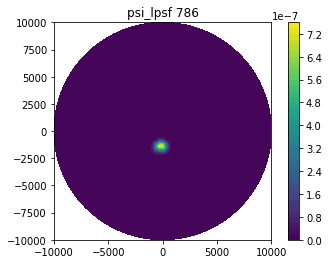

<Figure size 432x288 with 0 Axes>

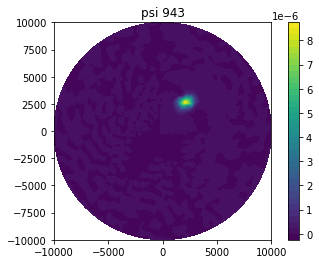

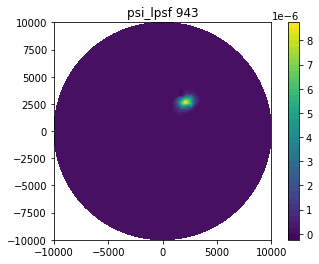

<Figure size 432x288 with 0 Axes>

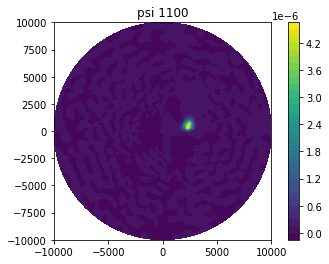

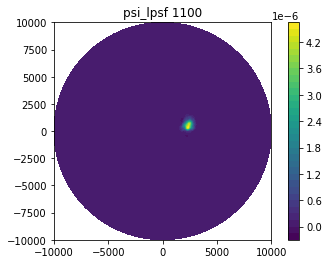

<Figure size 432x288 with 0 Axes>

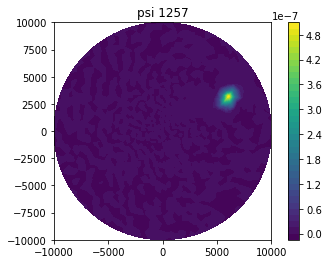

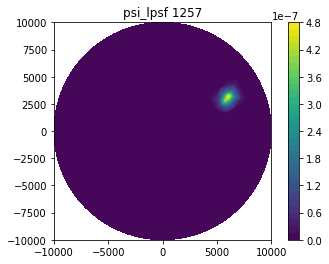

<Figure size 432x288 with 0 Axes>

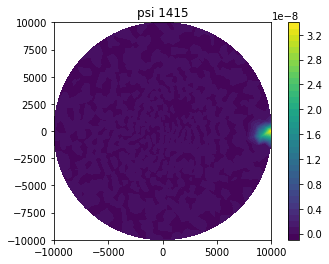

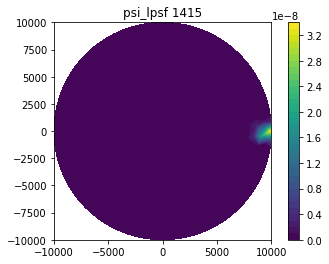

In [16]:
lpsf_kernel.num_neighbors = 10

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    plt.figure()
    psi_k = dl.Function(V)
    psi_k.vector()[:] = Ker[:,k].copy()

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.title('psi '+str(k))

    psi_k_lpsf = dl.Function(V)
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 1, 1).reshape(-1).copy()
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 2, 1).reshape(-1).copy()
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 3, 2).reshape(-1).copy()
    psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 0, 0).reshape(-1).copy()
    plt.figure()
    cm = dl.plot(psi_k_lpsf)
    plt.colorbar(cm)
    plt.title('psi_lpsf '+str(k))

In [17]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 35.350908279418945
err_Ker= 0.12014512161881237
err_Hdgn= 0.09355050366872802


Text(0.5, 1.0, 'col_errs_ker')

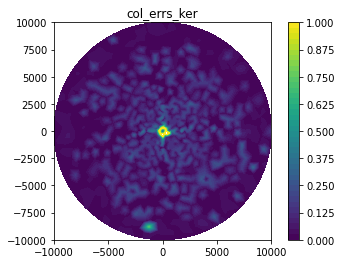

In [18]:
col_errs_ker_vec = np.linalg.norm(Ker_lpsf - Ker, axis=0) / np.linalg.norm(Ker, axis=0)
# col_errs_ker_vec = np.linalg.norm(Ker_lpsf - Ker, axis=0)

col_errs_ker = dl.Function(V)
# col_errs_ker.vector()[:] = np.log10(col_errs_ker_vec)
col_errs_ker.vector()[:] = np.min([col_errs_ker_vec, 5.0 * np.ones(V.dim())], axis=0)
cm = dl.plot(col_errs_ker)
plt.colorbar(cm)
plt.title('col_errs_ker')

Text(0.5, 1.0, 'col_errs')

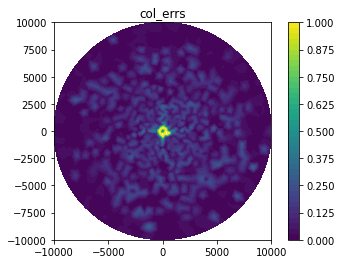

In [19]:
col_errs_vec = np.linalg.norm(Hdgn_lpsf - Hdgn, axis=0) / np.linalg.norm(Hdgn, axis=0)

col_errs = dl.Function(V)
# col_errs.vector()[:] = np.log10(col_errs_vec)
col_errs.vector()[:] = np.min([col_errs_vec, 5.0 * np.ones(V.dim())], axis=0)
cm = dl.plot(col_errs)
plt.colorbar(cm)
plt.title('col_errs')

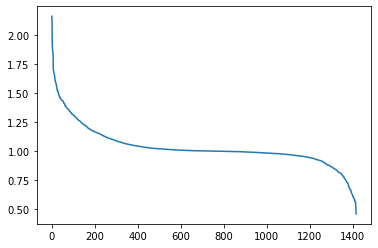

In [20]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_ELL, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.plot(ee_ELL[::-1])

In [21]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 33.3189914226532
err_Ker= 0.13162809848854273
err_Hdgn= 0.1050784497690489


In [22]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_LDMI, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

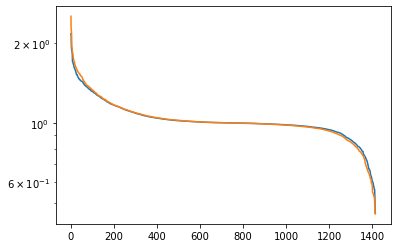

In [23]:
plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])

In [24]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 33.33634567260742
err_Ker= 0.2160841019802031
err_Hdgn= 0.16095181337896358


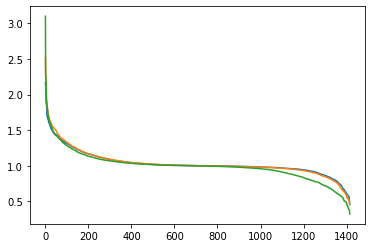

In [25]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_LTI, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.plot(ee_ELL[::-1])
plt.plot(ee_LDMI[::-1])
plt.plot(ee_LTI[::-1])

In [26]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 36.61483716964722
err_Ker= 0.32727937025182735
err_Hdgn= 0.2622521659035823


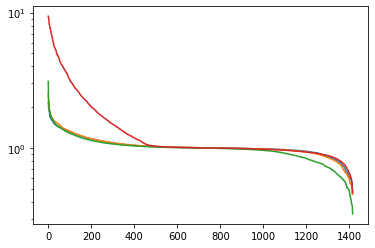

In [27]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_CUR, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])
plt.semilogy(ee_LTI[::-1])
plt.semilogy(ee_CUR[::-1])

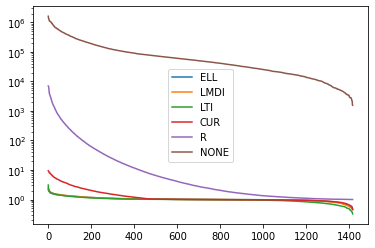

In [28]:
ee_R, U = sla.eigh(Hdgn + R, R)
ee_NONE, U = sla.eigh(Hdgn + R)

plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])
plt.semilogy(ee_LTI[::-1])
plt.semilogy(ee_CUR[::-1])
plt.semilogy(ee_R[::-1])
plt.semilogy(ee_NONE[::-1])
plt.legend(['ELL', 'LMDI', 'LTI', 'CUR', 'R', 'NONE'])

In [29]:
ee_ELL[-1] / ee_ELL[0]

4.7259579808751475

In [31]:
ee_LDMI[-1] / ee_LDMI[0]

5.526834731989037

In [32]:
ee_LTI[-1] / ee_LTI[0]

9.531369250474693

In [33]:
ee_CUR[-1] / ee_CUR[0]

20.072577068270448

In [34]:
ee_R[-1] / ee_R[0]

7010.350383928687

In [35]:
ee_NONE[-1] / ee_NONE[0]

1038.5243915791864